# Explanations:

- выборка - тензор из картинок, таргет - вектор силы

---

Авторы используют multi output GPR, настраивая гиперпараметры $\sigma_{cov}$ и $\sigma_{err}$ (можно однозначно их выразить через гиперпараметры из того же sklearn: $l$ и $\sigma$)

GPR - непараметрический метод, суть в том, что мы делаем предположение о виде матрицы корреляции признаков для известных данных.

---

Моделирование в хотя бы немного более сложном случае буду писать на Julia

---

Гиперпараметры:

1)k: Количество элементов в массивах r_cut и p для каждого атома

2)$r_{cut}(i)_j$, i=1..k, j=1..N: векторы r_cut для j атома тоже параметр

3)$p_(i)_j$, i=1..k, j=1..N: векторы p для j атома тоже параметр

4)N_neighbours for summation for IVs

В GPyTorch есть имплементация многоразмерного регрессора: https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/index.html#multi-output-vector-valued-functions

---

Пока что все размерности предполагаются в системе LJ, потому что пока пытаюсь это зафитить

Исходно пока в coords.csv и forces.csv находятся для 2 частиц данные

In [8]:
import random
import os
import time

from numba import jit, njit, vectorize
import numpy as np
import scipy
from numpy.linalg import norm as norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [9]:
def set_seed(seed = 42):
    '''
    
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.

    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

---

# Hyperparameters:

In [10]:
class CFG:
    '''

    All hyperparameters are here

    '''

    N = 2     # число атомов
    K = 2     # можно называть это разрешением...чем число больше, тем больше размеры матрицы для атомов, фактически это число элементов в наборах p и r_cut

    L = L = 2 * N ** (1 / 3)# размер одной клетки при моделировании

    p = (np.random.rand(K) + 0.1).copy()
    r_cut = (np.random.rand(K) + 0.1).copy()

    N_neig= N - 1 if N != 2 else 1

    # train_bs = 8
    # val_bs = 16
    batch_size = 8

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    f_threshold = 10    # Если сила по какой-то координате превышает это значение, то строчка исключается, совсем маленьких по модулю сил быть не должно, если что при генерации просто r_cut поменьше надо делать
    coord_threshold = 2 * L     # Если вдруг очень большие расстояния, то надо выкидывать
    #
    output_size = 3     # Размерность аутпута модели

---

Имеется два .csv файла:

1)
| Id(time) | 1_x | 1_y | 1_z | ... | N_z |
|------|-----|-----|-----|-----|-----|
|      |     |     |     |     |     |
|      |     |     |     |     |     |
2)
| Id(time) | f_1_x | f_1_y | f_1_z | ... | f_N_z |
|------|-----|-----|-----|-----|-----|
|      |     |     |     |     |     |
|      |     |     |     |     |     |

Одна строчка отсюда превращается в N матриц (на каждый атом) с N векторами сил

В идеале сделать БДху из двух сущностей: сила и координата, где полями будут их проекции

In [11]:
def create_df_with_coords(coords_file_path = None, forces_file_path = None):
    '''
    just makes df from .csvs with coords and forces
    '''
    coords = pd.read_csv(coords_file_path)

    forces = pd.read_csv(forces_file_path)

    if CFG.N != int(coords.columns[-1][:-1]) + 1:
        raise Exception('Constant N is not equal to amount of particles in .csv')

    return pd.merge(left=coords, right=forces, on='t').drop('t', axis='columns')

df = create_df_with_coords('coords.csv', 'forces.csv')
df

df.max()

0x          2.519317
0y          2.519801
0z        157.039283
1x        444.125151
1y          3.765265
1z          2.519838
0f_x     6300.708300
0f_y     4599.725992
0f_z      262.943956
1f_x    14945.975177
1f_y      525.511023
1f_z     1520.725800
dtype: float64

In [12]:
a = set([1, 2])
b = set([2, 3])

a.union(b)

{1, 2, 3}

12 индекс - 1 отн 2

$$
\vec{r_1} = \vec{r_2} + \vec{r}_{12}
$$

$$
\vec{r}_{12} = \vec{r_1} - \vec{r}_{2}
$$

In [13]:
def _get_relative_positions(row, atom_number):
    '''
    This function processes one row of csv into something that we can work with

    Returns np.array matrix that consists of relative positions vectors for passed atom_number to every other atom
    and then we can chose only closest N_neighbours in the next functions
    
    row: df.iloc[row] - typeof(row): pd.Series
    
    returns: Rel_matrix, f_vec
    '''

    s_coord = pd.Series(dtype=float)
    other_atom_numbers = [i for i in range(CFG.N) if i != atom_number]

    for other_numb in other_atom_numbers:
        index = str(atom_number) + str(other_numb)
        for axis in ['x', 'y', 'z']:
            s_coord[index + axis] = row[str(atom_number) + axis] - row[str(other_numb) + axis]

    # we need force vector only for atom_number:
    force_vec = []
    for f_axis in ['f_x', 'f_y', 'f_z']:
        force_vec.append(row[str(atom_number) + f_axis])
        

    Rel_matrix = []
    cur_vector = []

    for (i, elem) in enumerate(s_coord.values):
        if i % 3 == 0 and i != 0:
            Rel_matrix.append(cur_vector)
            cur_vector = []

        cur_vector.append(elem)
    Rel_matrix.append(cur_vector)

    return np.array(Rel_matrix), np.array(force_vec)

In [14]:
_get_relative_positions(df.iloc[0], 0)

(array([[-0.61478041,  0.82656999,  0.84915872]]),
 array([ 0.94574503, -1.2715507 , -1.30629998]))

In [15]:
from sklearn.preprocessing import normalize

In [16]:
@njit(fastmath=True)
def make_one_vec_transformed(vec, vec_norm, r_cut_i, p_i):
    '''
    vec: np.array - normalized vector
    norm: its norm
    r_cut_i: i-th component of
    '''
    return vec * np.exp(
        -np.power((vec_norm / r_cut_i), p_i)
        )

make_matrix_transformed = np.vectorize(make_one_vec_transformed)

def create_V_i(i, normalized_m, norms, r_cut=CFG.r_cut, p=CFG.p):
    '''
    normalized_m: matrix of relative distances, where rows - normalized vectors
    i: i-th component of r_cut and p, i in range 1..K (or in 0..K-1 in code)
    '''
    transf_vecs = make_matrix_transformed(normalized_m, norms[:, np.newaxis], r_cut[i], p[i])

    return np.sum(transf_vecs, axis=0)

# @njit(parallel=True)
def create_V(normalized_m, norms, K=CFG.K):
    '''
    creates V
    '''
    V = []
    for i in range(K):
        V.append(
            create_V_i(i, normalized_m, norms)
        )

    return np.array(V)

In [17]:
# @njit(
#     # parallel=True,
#     # fastmath=True
#     )
def _calculate_matrix_for_atom(relative_distances, r_cut=CFG.r_cut, p=CFG.p, N_neig=CFG.N_neig, K=CFG.K):
    '''

    relative_distances: np.array matrix of relative distance vectors

    '''

    norms = norm(relative_distances, axis=-1)
    
    # Only closest N_neig are counting:
    indexlist = np.argsort(norm(relative_distances, axis=1))
    relative_distances = relative_distances[indexlist[len(relative_distances) - N_neig:]]

    normalized_rel_distances = relative_distances / norms[:, np.newaxis]

    # print(
    #     create_V_i(0, normalized_rel_distances, norms), f'{CFG.r_cut=}, {CFG.p=}'
    # )

    V = create_V(normalized_rel_distances, norms)

    # print(f'V:\n {V}\n norms:\n {norm(V, axis=-1)[:, np.newaxis]}\n normed_V:\n {V / norm(V, axis=-1)[:, np.newaxis]}')
    
    # print(V / norm(V, axis=-1)[:, np.newaxis])
    if np.inf in V / norm(V, axis=-1)[:, np.newaxis] or np.nan in V / norm(V, axis=-1)[:, np.newaxis]:
        print(f'V:\n {V}\n norms:\n {norm(V, axis=-1)[:, np.newaxis]}\n normed_V:\n {V / norm(V, axis=-1)[:, np.newaxis]}')
        print(f'ABOUT RELATIVE DISTANCES:\n rel_dists:\n {relative_distances}\n norms:\n{norms}\n normalized_rel_dists:\n {normalized_rel_distances}')

    A = V / norm(V, axis=-1)[:, np.newaxis]

    X = V @ A.T

    return X

In [18]:
def get_matrix_for_atom(row = None, atom_number = None):
    '''

    This function will create X matrix for passed atom with
    arrays of r_cut and p of length k

    It is a wrapper for _get_relative_positions and _calculate_matrix_for_atom, so I can speed up matrix calculations
    with numba for _calculate_matrix_for_atom

    atom_number: a number of atom that we are passing
    row: one row from df_with_coords, i.e. df.iloc[index_of_row]

    '''

    # creating row of relative coordinates for concrete atom:
    relative_distances, f_vec = _get_relative_positions(row=row, atom_number=atom_number)
    X = _calculate_matrix_for_atom(relative_distances=relative_distances)
    
    return X, f_vec

# %timeit get_matrix_for_atom(row=df.iloc[0], atom_number=1)

In [19]:
from tqdm import tqdm
import gc
import torchvision.transforms as transforms

**У нас будет train и val выборки, все-таки выборку, для который известен таргет принято называть validation, на которой мы качество оцениваем, а test это все-таки выборка, для который неизвестны таргеты**

In [20]:
def clean_df(df: pd.DataFrame, f_threshold = CFG.f_threshold, coord_threshold=CFG.coord_threshold):
    '''

    Убирает строчки с аномально большими силами из df

    '''

    indexes_for_deletion = set()

    for numb in range(CFG.N):
        for coord in ['f_x', 'f_y', 'f_z']:

            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > f_threshold].index)
            )

        for coord in ['x', 'y', 'z']:
            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > coord_threshold].index)
            )

    return df.drop(list(indexes_for_deletion))

In [21]:
def create_tensor_dataset(coords_file_path = 'coords.csv', forces_file_path = 'forces.csv', step=1, transform=None, length=None,
    f_threshold=CFG.f_threshold, coord_threshold=CFG.coord_threshold):
    '''

    Примитивная версия датасета, просто все будет хранить в одном тензоре...

    Эта функция - wrapper на все выше написанные функции, она по переданным путям к .csv
    возвращает тензор из матриц для каждого атома в каждой строчке и тензор из векторов сил


    ИНогда есть смысл делать побольше шаг между соседними строчками, поскольку если есть почти одинаковые матрицы, то
    это по-сути линейная зависимость и модель тогда надо сильнее регулизировать

    transform: преобразование к X части датасета, в основном для нормализации нужно
    step: через сколько строчек шагать при чтении csv в датасет, чтобы уж совсем одинаковых не было

    '''

    dataset = []

    df = create_df_with_coords(coords_file_path=coords_file_path, forces_file_path=forces_file_path)
    if length:
        df = df.loc[range(length)]

    # Сюда будет вставлена чистка df от больших сил
    df = clean_df(df, f_threshold=f_threshold, coord_threshold=coord_threshold)

    row_indexes = [i for i in range(0, len(df.index), step)]

    for atom_number in range(CFG.N):
        for index in tqdm(row_indexes, desc=f'Progress for atom {atom_number}'):
            row = df.iloc[index]
            x, f = get_matrix_for_atom(row=row, atom_number=atom_number)

            if transform:
                x = transform(x)
            else:
                x = transforms.ToTensor()(x)
            x = x.to(torch.float)

            dataset.append(
                (x, torch.tensor(f, dtype=torch.float))
                )
            
            # В дальнейшем для других моделей может иметь смысл хранить и возвращать тут (x, f, A), где A - соответствующая матрица для X

    gc.collect()

    return dataset

In [22]:
# Когда только начинаю работать с датасетом надо один раз на трейне посчитать std и mean, чтобы нормализовать можно было

mean = -0.2662966549396515
std = 0.9410921335220337

In [23]:
# все-таки у нас тут не картинки будут, поэтому я попробую сначала даже без нормализации, нормализовать надо 1 канал, если в терминах картинки рассуждать

transform = transforms.Compose([                                    
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),                    
])

In [24]:
dataset = create_tensor_dataset('coords.csv', 'forces.csv', step=2, transform=transform)

Progress for atom 1: 100%|██████████| 9313/9313 [00:14<00:00, 651.93it/s]


Пока никакие параметры особо не надо настраивать, поэтому и кросс валидацию не буду делать пока что, затем ее можно сделать, передавая в функцию create_dataloaders еще один параметр - фолд, на котором трейн, предварительно поделив на фолды датасет

Если просто брать в качестве трейна другие строчки из одной генерации, то можно не отследить переобучения, стоит пробовать тестить на датасете, который отдельно сгенерирован с таким же числом частиц, который модель еще вообще не видела

In [25]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(dataset, test_size=0.33, random_state=42)

train_data[62]

(tensor([[[0.4573, 0.4573],
          [0.2953, 0.2953]]]),
 tensor([ 0.0049, -0.0053, -0.0120]))

**Код для выяснения mean и std у трейновой выборки: (по ненормализованному датасету делается)** 

In [26]:
def get_mean_and_std_for_train_X(train_data):
    train_X = torch.cat([row[0] for row in train_data])

    print(
        f'mean = {torch.mean(train_X)}, std = {torch.std(train_X)}'
    )

get_mean_and_std_for_train_X(train_data=train_data) # тупо проверка

mean = 0.4100044369697571, std = 0.09590677171945572


## Когда молекул уже будет много как хранить данные:

In [27]:
# Эта клетка нужна будет, когда молекул будет много (N > 100, K порядка 100)

def create_df_with_paths(df_coords: pd.DataFrame, first_folder = 'Atom_matrices'):
    '''

    Пока эта функция не нужна, но в будущем за счет нее как раз будет работать PathBasedDataset

    gets df, returns df with paths to torch matrices for each atom for different times,
    basically this function will call get_matrix_for_atom a lot of times

    output: pd.DataFrame that orignated from this:
    
    | Index | 1_atom_X_path                     | ... | N_atom_X_path                     |
    |-------|-----------------------------------|-----|-----------------------------------|
    | 1     | ./atom_matrices/index1/atom1.tb   |     | ./atom_matrices/index1/atomN.tb   |
    | ...   |                                   |     |                                   |
    | 30k   | ./atom_matrices/index30k/atom1.tb |     | ./atom_matrices/index30k/atomN.tb |
    
    but eventually will look like this:

    | Index   | atom_X_path                       |
    |---------|-----------------------------------|
    | 1       | ./atom_matrices/index1/atom1.tb   |
    | ...     | ...                               |
    | 30k * N | ./atom_matrices/index30k/atomN.tb |

    '''
    row_numbers = df_coords.index

    df_paths = pd.DataFrame(
        {
            'path': []
        }
    )

    pass

class PathBasedDataset(torch.utils.data.Dataset):
    '''

    Это будет класс датасета из торча для большого числа молекул, если молекул будет очень много, то надо будет уже хранить все матрицы X не в оперативной памяти

    При создании экземпляра будет передаваться pd.Dataframe, который
    состоит из трех колонок - проекций вектора силы и еще одной колонки - путь к файлу, где лежит как-то заэнкоженная
    матрица для данного атома, и так для каждого атома (я проверил, что запись и чтение при помощи torch.save и torch.load для тензоров очень быстрое)

    '''
    def __init__(self, df, transforms=None, mode='train'):
        self.df = df    # it will be dataframe with coordinates and forces of all atoms
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        x = 1   # it will be a matrix KxK for each atom
        y = 1   # it will be a force vector with shape: (3)

        if self.mode == 'test':
            return x
        return x, y

In [28]:
from torch.utils.data import DataLoader

In [29]:
def create_dataloaders(train_dataset, val_dataset, train_bs=CFG.batch_size, val_bs=CFG.batch_size, fold=None):
    '''

    Returns train_loader, val_loader

    fold: will be used in cross validation, when I will implement it

    '''
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=train_bs, shuffle=True)

    val_loader = DataLoader(dataset=val_dataset, batch_size=val_bs, shuffle=False)

    return train_loader, val_loader

In [30]:
train_loader, val_loader = create_dataloaders(train_data, val_data)

---

# Обучение:

In [31]:
from torch.utils.tensorboard import SummaryWriter

Я попробую оба варианта:
1) Многомерный аутпут
2) Для каждой компоненты свой одномерный аутпут

надо помнить, что сначала на двух частицах!

## 1)Многомерный аутпут:

In [32]:
import torch.nn.functional as F

Вообще постоянный множитель - это не особо важно, но просто при оценке качества модели возникнут определенные трудности

In [33]:
class MultuOutputMSELoss(nn.MSELoss):
    '''

    Custom loss that calculates average over batch loss for multidim MSE - sum of MSE for components

    Example:
    |
    |    Loss = MultuOutputMSELoss()
    |
    |    a = torch.ones((8, 3))      # it is batch of 8 vectors of size 3
    |    b = torch.zeros((8, 3))
    |
    |    Loss(a, b, batch_size=8) -> 3

    '''

    def forward(self, input, target, batch_size=CFG.batch_size):
        '''
        оно при reduction='mean' делит на произведение всех размерностей
        '''
        return F.mse_loss(input, target, reduction='sum') / batch_size   # или эквивалентно делать reduction='mean' и умножать на input.size()[-1] - length of output

In [34]:
L = MultuOutputMSELoss()

a = torch.tensor([
    [1, 2, 3],
    [1, 2, 3],
    [1, 2, 3],
    [1, 2, 3],
    [1, 2, 3]
])
b = torch.tensor([
    [1, 0, 1],
    [1, 0, 0],
    [1, 0, 0],
    [1, 0, 1],
    [1, 0, 1]
], dtype=torch.double)

L(a, b, 5)

tensor(10., dtype=torch.float64)

In [35]:
class SingleNet(nn.Module):
    def __init__(self, output_size):
        super().__init__()

        # Когда будет много частиц, здесь можно свертки и пуллинги запихать, в FC сетку уже надо подавать распрямленную матрицу
        # self.conv1 = ...

        self.fully_connected = nn.Sequential(
            nn.Linear(CFG.K * CFG.K, 1024),
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, 512),
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.BatchNorm1d(512),
            nn.Linear(512, output_size),
        )

        # self.fully_connected = nn.Sequential(
        #     nn.Linear(CFG.K * CFG.K, 128),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(128),

        #     nn.Linear(128, 256),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(256),

        #     nn.Linear(256, 512),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(512),

        #     nn.Linear(512, 1024),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(1024),

        #     nn.Linear(1024, 1024),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(1024),

        #     nn.Linear(1024, 1024),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(1024),
        #     nn.Linear(1024, output_size),
        # )

    def forward(self, x):
        # x - is batch of matrices KxK

        # Здесь происходят какие-то там свертки, пуллинги и тп...

        x = x.view(x.size(0), -1)

        x = self.fully_connected(x)

        return x

В качестве метрики буду использовать сумму MSE по компонентам, лоссы попробую разные

In [36]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler=None):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    '''
    running_loss = 0.0
    running_MSE = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        
        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_MSE += F.mse_loss(input=outputs, target=labels, reduction='sum').item()
        processed_data += inputs.size(0)

    scheduler.step()
              
    train_loss = running_loss / processed_data
    train_MSE = running_MSE / processed_data
    
    return train_loss, train_MSE

In [37]:
def eval_epoch(model, val_loader, criterion):

    model.eval()
    
    running_loss = 0.0
    running_MSE = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_MSE += F.mse_loss(input=outputs, target=labels, reduction='sum')
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_MSE = running_MSE.double().item() / processed_size
    
    return val_loss, val_MSE

In [38]:
def train(train_loader, val_loader, model, optimizer, scheduler, epochs, scaler=None, criterion=MultuOutputMSELoss()):
    '''

    Полный цикл обучения
    
    '''

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_MSE {t_mse:0.4f} val_MSE {v_mse:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_MSE = fit_epoch(model, train_loader, criterion, optimizer, scheduler)

            val_loss, val_MSE = eval_epoch(model, val_loader, criterion)
            if epoch != 0:
                if history[-1][-1] < val_MSE:
                    torch.save(model.state_dict(), './model.pth')     # сохраняем модель напрямую в гугл диск 
            
            history.append((train_loss, train_MSE, val_loss, val_MSE))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_mse=train_MSE, v_mse=val_MSE))
            
            
    return history

In [39]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [40]:
model = SingleNet(output_size=CFG.output_size).to(CFG.device)

optimizer = optim.Adam(model.parameters(), lr=4e-3, betas=(0.9, 0.999), weight_decay=0.1)

# scheduler.step нужно первый раз делать обязательно после optimizer.step, потому что иначе мы просто пропустим первый шаг scheduler
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Попытка для двух частиц:

In [41]:
history = train(
    train_loader=train_loader, val_loader=val_loader, model=model, optimizer=optimizer,
    scheduler=exp_scheduler, epochs=10
)

epoch:  10%|█         | 1/10 [00:04<00:37,  4.19s/it]


Epoch 001 train_loss: 0.9314     val_loss 0.7297 train_MSE 0.9325 val_MSE 0.7297


epoch:  20%|██        | 2/10 [00:07<00:31,  3.93s/it]


Epoch 002 train_loss: 0.8496     val_loss 0.7316 train_MSE 0.8496 val_MSE 0.7317


epoch:  30%|███       | 3/10 [00:11<00:27,  3.87s/it]


Epoch 003 train_loss: 0.8495     val_loss 0.7291 train_MSE 0.8495 val_MSE 0.7291


epoch:  40%|████      | 4/10 [00:15<00:22,  3.76s/it]


Epoch 004 train_loss: 0.8497     val_loss 0.7288 train_MSE 0.8497 val_MSE 0.7288


epoch:  50%|█████     | 5/10 [00:18<00:18,  3.71s/it]


Epoch 005 train_loss: 0.8556     val_loss 0.7319 train_MSE 0.8556 val_MSE 0.7319


epoch:  60%|██████    | 6/10 [00:22<00:14,  3.68s/it]


Epoch 006 train_loss: 0.8487     val_loss 0.7286 train_MSE 0.8487 val_MSE 0.7287


epoch:  70%|███████   | 7/10 [00:26<00:11,  3.67s/it]


Epoch 007 train_loss: 0.8486     val_loss 0.7287 train_MSE 0.8486 val_MSE 0.7287


epoch:  80%|████████  | 8/10 [00:29<00:07,  3.65s/it]


Epoch 008 train_loss: 0.8484     val_loss 0.7283 train_MSE 0.8485 val_MSE 0.7283


epoch:  90%|█████████ | 9/10 [00:33<00:03,  3.64s/it]


Epoch 009 train_loss: 0.8485     val_loss 0.7284 train_MSE 0.8485 val_MSE 0.7284


epoch: 100%|██████████| 10/10 [00:37<00:00,  3.70s/it]


Epoch 010 train_loss: 0.8485     val_loss 0.7288 train_MSE 0.8485 val_MSE 0.7288


In [42]:

def plot_history(history, figsize=(40, 15)):
    '''

    history: [(train_loss, train_MSE, val_loss, val_MSE), ...]

    '''

    # writer = SummaryWriter()
    
    figure = plt.figure(figsize=figsize)

    train_loss = [tup[0] for tup in history]
    train_MSE = [tup[1] for tup in history]
    val_loss = [tup[2] for tup in history]
    val_MSE = [tup[3] for tup in history]

    plt.subplot(1, 2, 1)

    plt.plot(range(1, len(history) + 1), train_loss, label='train_loss')
    plt.plot(range(1, len(history) + 1), val_loss, label='val_loss')
    
    plt.title('Losses', fontsize=16)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)     
    plt.xticks(np.arange(1, len(history) + 1, 1))
    # plt.yticks(np.arange(1, len(history) + 1, 1))
    plt.legend(loc='best')
    #
    plt.subplot(1, 2, 2)

    plt.plot(range(1, len(history) + 1), train_MSE, label='train_MSE')
    plt.plot(range(1, len(history) + 1), val_MSE, label='val_MSE')
    
    plt.title('Metrics', fontsize=16)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)     
    plt.xticks(np.arange(1, len(history) + 1, 1))
    # plt.yticks(np.arange(1, len(history) + 1, 1))
    plt.legend(loc='best', fontsize=14)
    
    plt.show()

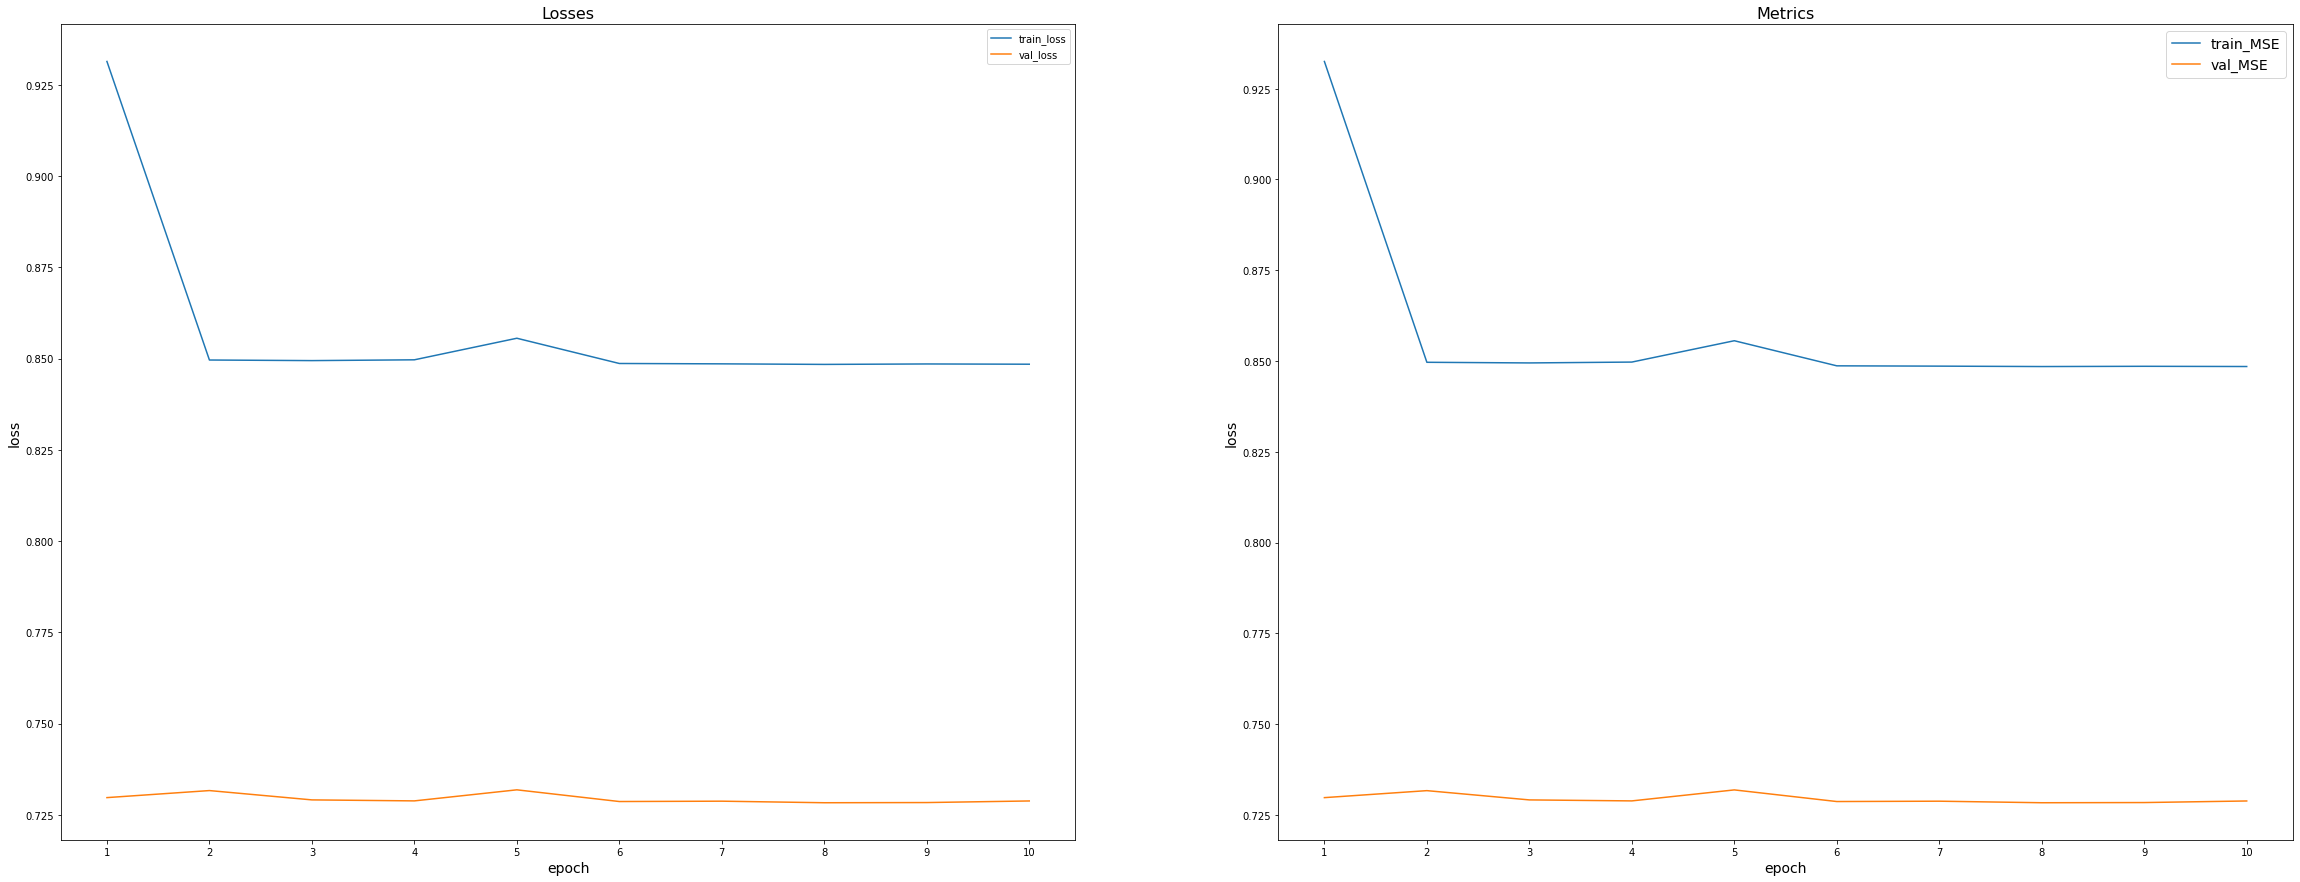

In [43]:
plot_history(history=history)

# 2) Output_size сеток с одномерным аутпутом (предполагаем независимость всех компонент силы)

Просто обучаю набор сеток на задачу регрессии, в качестве метрики для каждой сетки буду использовать MSE, а итоговая метрика - сумма MSE для каждой сетки

(Просто делаю массив из экземпляров сеток, optim-ов, loss-ов и потом циклом по ним делаю ровно тот же самый вызов history )

In [56]:
# Всем сеткам делаю абсолютно одинаковые гиперпараметры

models = [SingleNet(output_size=1) for _ in range(CFG.output_size)]

lr = 4e-3
betas=(0.9, 0.999)
weight_decay=0.1

optims = [optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay) for model in models]

step_size = 5
gamma = 0.1

exp_schedulers = [lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) for optimizer in optims]

criterion = nn.MSELoss()

In [57]:
from collections import defaultdict

Самое главное при обучении этих моделей - то что у model[ i ] - таргет - это число force[ i ]

In [52]:
def train_models():
    '''
    
    Возвращает словарь из history для всех моделей: {1: history, 2: history, ...}

    '''

    histories = defaultdict(list)

    # Надо менять немного цикл обучения, чтобы таргетом для i сетки была i-ая компонента вектора силы

    # for i in range(CFG.output_size):
    #     histories[str(i)] = train(
    #         train_loader=train_loader,
    #         val_loader=val_loader,
    #         model=model,
    #         optimizer=optimizer,
    #         scheduler=exp_scheduler,
    #         criterion=nn.MSELoss(),
    #         epochs=10
    #     )

In [3]:
d = defaultdict(list)

d['a'].append(1)

In [6]:
d.keys()

dict_keys(['a'])

In [60]:
d['1'] = [i for i in range(5)]

In [61]:
d

defaultdict(list, {'a': 1, '1': [0, 1, 2, 3, 4]})